In [ ]:
#| hide
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
#| default_exp models.kan

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# KAN

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional, Union

import math

import torch
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [ ]:
#| export
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [ ]:
#| export

class KAN(BaseWindows):
    """ KAN

    Simple Kolmogorov-Arnold Network (KAN).
    This network uses the Kolmogorov-Arnold approximation theorem, where splines
    are learned to approximate more complex functions. Unlike the MLP, the
    non-linear function are learned at the edges, and the nodes simply sum
    the different learned functions.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `grid_size`: int, number of intervals used by the splines to approximate the function.<br>
    `spline_order`: int, order of the B-splines.<br>
    `scale_noise`: float, regularization coefficient for the splines.<br>
    `scale_base`: float, scaling coefficient for the base function.<br>
    `scale_spline`: float, scaling coefficient for the splines.<br>
    `enable_standalone_scale_spline`: bool, whether each spline is scaled individually.<br>
    `grid_eps`: float, used for numerical stability.<br>
    `grid_range`: list, range of the grid used for spline approximation.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `n_hidden_layers`: int, number of hidden layers for the KAN.<br>
    `hidden_size`: int or list, number of units for each hidden layer of the KAN. If an integer, all hidden layers will have the same size. Use a list to specify the size of each hidden layer.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """

    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h,
                 input_size,
                 grid_size: int = 5,
                 spline_order: int = 3,
                 scale_noise: float = 0.1,
                 scale_base: float = 1.0,
                 scale_spline: float = 1.0,
                 enable_standalone_scale_spline: bool = True,
                 grid_eps: float = 0.02,
                 grid_range: list = [-1, 1],
                 n_hidden_layers: int = 1,
                 hidden_size: Union[int, list] = 512,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 **trainer_kwargs):
        
        # Inherit BaseWindows class
        super(KAN, self).__init__(h=h,
                                  input_size=input_size,
                                  futr_exog_list=futr_exog_list,
                                  hist_exog_list=hist_exog_list,
                                  stat_exog_list=stat_exog_list,
                                  exclude_insample_y = exclude_insample_y,
                                  loss=loss,
                                  valid_loss=valid_loss,
                                  max_steps=max_steps,
                                  learning_rate=learning_rate,
                                  num_lr_decays=num_lr_decays,
                                  early_stop_patience_steps=early_stop_patience_steps,
                                  val_check_steps=val_check_steps,
                                  batch_size=batch_size,
                                  valid_batch_size=valid_batch_size,
                                  windows_batch_size=windows_batch_size,
                                  inference_windows_batch_size=inference_windows_batch_size,
                                  start_padding_enabled=start_padding_enabled,
                                  step_size=step_size,
                                  scaler_type=scaler_type,
                                  num_workers_loader=num_workers_loader,
                                  drop_last_loader=drop_last_loader,
                                  random_seed=random_seed,
                                  optimizer=optimizer,
                                  optimizer_kwargs=optimizer_kwargs,
                                  **trainer_kwargs)
        
        # Asserts
        if stat_exog_list is not None:
            raise Exception("KAN does not yet support static exogenous variables")
        if futr_exog_list is not None:
            raise Exception("KAN does not yet support future exogenous variables")
        if hist_exog_list is not None:
            raise Exception("KAN does not yet support historical exogenous variables")
        
        # Architecture
        self.n_hidden_layers = n_hidden_layers
        self.hidden_size = hidden_size
        
        if isinstance(self.hidden_size, int):
            self.hidden_layers = [self.input_size] + [self.hidden_size for _ in range(self.n_hidden_layers)] + [self.h]
        elif isinstance(self.hidden_size, list):
            if len(self.hidden_size) != self.n_hidden_layers:
                raise Exception("The number of elements in the list hidden_size must equal the number of n_hidden_layers")
            self.hidden_layers = [self.input_size] + self.hidden_size + [self.h]
            
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = torch.nn.SiLU
        self.grid_eps = grid_eps
        self.grid_range = grid_range

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(self.hidden_layers, self.hidden_layers[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=self.spline_order,
                    scale_noise=self.scale_noise,
                    scale_base=self.scale_base,
                    scale_spline=self.scale_spline,
                    base_activation=self.base_activation,
                    grid_eps=self.grid_eps,
                    grid_range=self.grid_range,
                )
            )


    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )
        
    def forward(self, windows_batch, update_grid=False):

        insample_y = windows_batch['insample_y']

        y_pred = insample_y.clone()

        for layer in self.layers:
            if update_grid:
                layer.update_grid(y_pred)
            y_pred = layer(y_pred)

        y_pred = self.loss.domain_map(y_pred)

        return y_pred
        

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import KAN
from neuralforecast.losses.pytorch import MAE
from neuralforecast.utils import AirPassengersPanel

In [ ]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = KAN(h=12, input_size=24,
            loss=MAE(),
            scaler_type='robust',
            learning_rate=1e-3,
            max_steps=200,
            val_check_steps=10,
            early_stop_patience_steps=2)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)

fcst.fit(df=Y_train_df, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | layers       | ModuleList    | 184 K 
-----------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.737     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/utilsforecast/processing.py:362: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/utilsforecast/processing.py:414: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/dev/neuralforecast/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[]

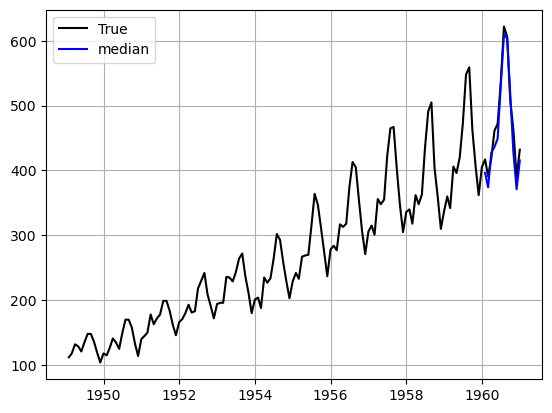

In [ ]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['KAN'], c='blue', label='median')
plt.grid()
plt.legend()
plt.plot()